In [113]:
# Load and prepare the data

import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import training_data as td
from PIL import Image
from matplotlib import pyplot as plt

def print_data_infos(data_test):
    print("Test data length: {0}".format(len(data_test.data)))
    print("Img Shape: {0}".format(data_test.data[0].shape))
    print("Number of Labels: {0}".format(data_test.no_labels))
    
data_all_test = td.DataCollection(train=False)
print_data_infos(data_all_test)

100%|██████████| 10000/10000 [00:00<00:00, 197860.39it/s]

No training data for 0. Skipping
No training data for 1. Skipping
No training data for 2. Skipping
No training data for 3. Skipping
No training data for 4. Skipping
No training data for 5. Skipping
No training data for 6. Skipping
No training data for 7. Skipping
No training data for 8. Skipping
No training data for 9. Skipping
No training data for +. Skipping
No training data for -. Skipping
No training data for div. Skipping
No training data for brckts. Skipping
No training data for ). Skipping
Test data length: 10072
Img Shape: torch.Size([1, 32, 32])
Number of Labels: 15


In [99]:
from torchvision.models import alexnet
from torch.nn import Conv2d
import numpy as np

def classify(imgs, model_all, model_ops, model_brckts):
    pred_all = model_all(imgs).detach().numpy()
    labels_all = np.argmax(pred_all, axis=1)
    pred_best_all = np.max(pred_all, axis=1)[None,:]
    
    pred_ops = model_ops(imgs).detach().numpy()
    labels_ops = np.argmax(pred_ops, axis=1)
    pred_best_ops = np.max(pred_ops, axis=1)[None,:]
    
    pred_brckts = model_brckts(imgs).detach().numpy()
    labels_brckts = np.argmax(pred_brckts, axis=1)
    pred_best_brckts = np.max(pred_brckts, axis=1)[None,:]
    
    best_preds = np.concatenate((pred_best_all.T, pred_best_ops.T), axis=1)
    best_preds = np.argmax(np.concatenate((best_preds, pred_best_brckts.T), axis=1), axis=1)
    labels = np.where(best_preds == 1, labels_ops, labels_all)
    labels = np.where(best_preds == 2, labels_brckts, labels)
    return labels

In [105]:
# TODO: !! Change number of classes and model paths
num_classes = 15
model_all = alexnet(num_classes=num_classes)
model_all.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_all.load_state_dict(torch.load('mlmodels/model-all-symbols.ckpt', map_location="cpu"))

model_ops = alexnet(num_classes=num_classes)
model_ops.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ops.load_state_dict(torch.load('mlmodels/model-plus-minus-div.ckpt', map_location="cpu"))

model_brckts = alexnet(num_classes=num_classes)
model_brckts.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_brckts.load_state_dict(torch.load('mlmodels/model-plus-brackets.ckpt', map_location="cpu"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [131]:


imgs = torch.nn.utils.rnn.pad_sequence(data_all_test.data, batch_first=True, padding_value=0)
#labels = classify(imgs, model_all, model_ops, model_brckts)
labels = torch.argmax(model_all(imgs), dim=1).detach().numpy()

In [133]:
confusion_matrix = np.zeros((num_classes+1, num_classes+1))   
for i in range(labels.shape[0]):
    ground_truth = data_all_test.targets[i]
    label = labels[i]
    confusion_matrix[ground_truth][label] = int(confusion_matrix[ground_truth][label]) + 1


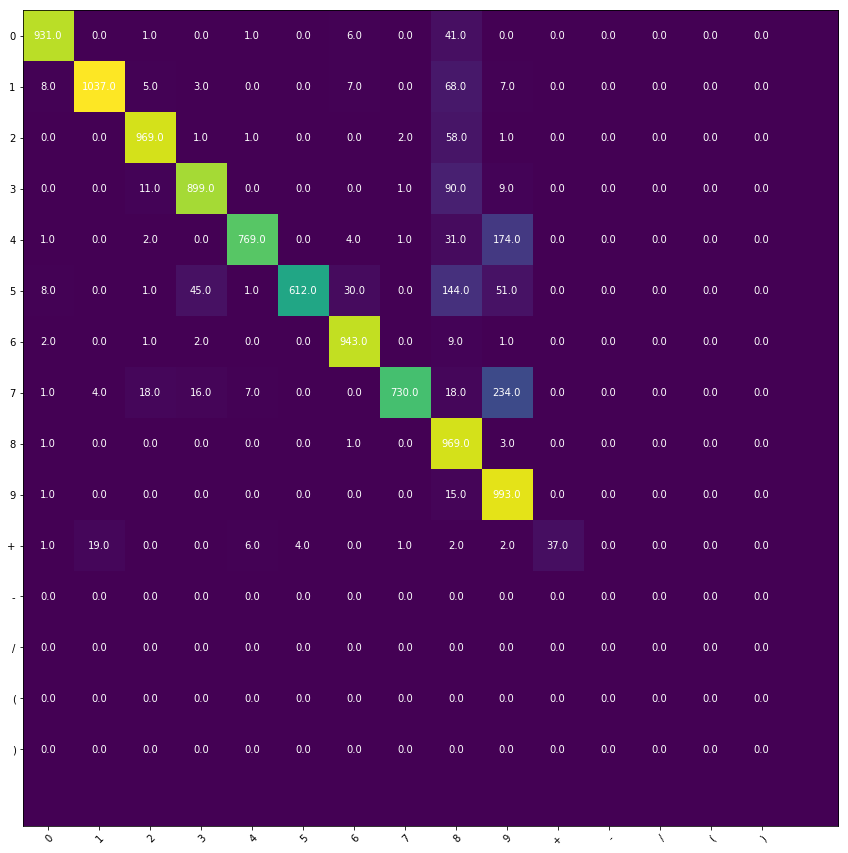

In [134]:
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(confusion_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
# ... and label them with the respective list entries
ax.set_xticklabels(td.MATH_SYMBOLS)
ax.set_yticklabels(td.MATH_SYMBOLS)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")

plt.show()
